
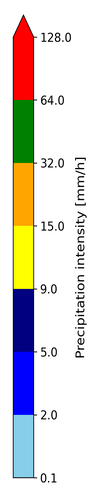
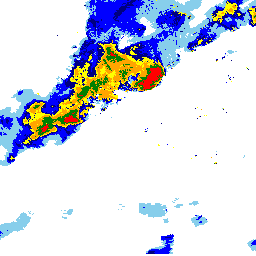

In [5]:
import os
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import folium
from PIL import Image
from folium.plugins import FloatImage
import base64

# Define the custom colormap class


class ColormapConfig:
    def __init__(self):
        self.cmap = None
        self.norm = None
        self.clevs = None
        self.bounds = None

        self.build_colormap()

    def build_colormap(self):
        # Shortened version of Eric's custom colormap
        color_list = ["skyblue", "blue", "navy", "yellow", "orange", "green", "brown", "red"]
        self.clevs = [0.1, 2, 5, 9, 15, 32, 64, 128]  # Precipitation intensity levels
        self.bounds = [0.1, 2, 5, 9, 15, 32, 64, 128]  #

        self.cmap = mcolors.ListedColormap(color_list)
        self.cmap.set_over("red")
        self.cmap.set_under("none")
        self.cmap.set_bad("gray", alpha=0.5)
        self.norm = mcolors.BoundaryNorm(self.clevs, self.cmap.N)
        self.cmap.name = "Custom Colormap"


cmap_config = ColormapConfig()

# Paths to the netCDF data
data_path_new = "/work/pi_mzink_umass_edu/SPRITE/skillful_nowcasting/netCDFData_sequenced_203/train/seq-24-711-0.0000148/20180908_151848.nc"
data_path_old = "/work/pi_mzink_umass_edu/SPRITE/skillful_nowcasting/netCDFData/train/20180908/20180908_151848.nc"

# Open the new netCDF file and extract data
nc_new = Dataset(data_path_new, "r")
data_new = np.array(nc_new.variables["RRdata"][:])  # Replace with the correct variable name if different
nc_new.close()

# Open the old netCDF file and extract geodata
nc_old = Dataset(data_path_old, "r")
x_coords = np.array(nc_old.variables["x0"][:])  # Read x-coordinates
y_coords = np.array(nc_old.variables["y0"][:])  # Read y-coordinates
nc_old.close()


# Now, apply the cropping and resizing as in your provided code
def crop_center(data, crop_height, crop_width):
    h, w = data.shape[-2:]
    start_h = h // 2 - (crop_height // 2)
    start_w = w // 2 - (crop_width // 2)
    return data[..., start_h : start_h + crop_height, start_w : start_w + crop_width]


# Define the crop size
crop_size = (256, 256)  # height, width

# Apply cropping
data_cropped = crop_center(data_new, crop_size[0], crop_size[1])

# Adjust geodata accordingly
h_total, w_total = data_new.shape[-2:]
start_h = h_total // 2 - (crop_size[0] // 2)
start_w = w_total // 2 - (crop_size[1] // 2)
end_h = start_h + crop_size[0]
end_w = start_w + crop_size[1]

# Since x_coords and y_coords might be 1D or 2D, adjust accordingly
if x_coords.ndim > 1:
    x_coords_cropped = x_coords[start_h:end_h, start_w:end_w]
    y_coords_cropped = y_coords[start_h:end_h, start_w:end_w]
else:
    x_coords_cropped = x_coords[start_w:end_w]
    y_coords_cropped = y_coords[start_h:end_h]

# Update the bounds
x_min_cropped = float(x_coords_cropped.min())
x_max_cropped = float(x_coords_cropped.max())
y_min_cropped = float(y_coords_cropped.min())
y_max_cropped = float(y_coords_cropped.max())

# Calculate the center of the map
center_lat = (y_min_cropped + y_max_cropped) / 2
center_lon = (x_min_cropped + x_max_cropped) / 2

# Names and paths
overlay_image_name = "overlay_image2.png"
colorbar_filename = "colorbar2.png"
html_filename = "NetCDF_Map2.html"
output_folder = "./file2"  # Change this if you want to save to a different directory

os.makedirs(output_folder, exist_ok=True)


# Function to create and save a colorbar image with adjustments
def create_colorbar(cmap_config, filename="colorbar.png", orientation="vertical"):
    cmap = cmap_config.cmap
    norm = cmap_config.norm
    clevs = cmap_config.clevs
    bounds = cmap_config.bounds

    # Adjust the figure size and colorbar axis to create white space and a thinner colorbar
    fig, ax = plt.subplots(figsize=(0.4, 8)) if orientation == "vertical" else plt.subplots(figsize=(8, 0.4))
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = plt.colorbar(
        sm,
        cax=ax,
        orientation=orientation,
        boundaries=clevs,
        ticks=bounds,
        extend="max",  # Only show the pointer on the top
        pad=0.05,  # Add padding between the colorbar and the main image
    )
    cb.set_label("Precipitation intensity [mm/h]", size=13)

    # Set font size for tick labels
    cb.ax.tick_params(labelsize=12)

    # Save colorbar with white space around it
    fig.savefig(filename, dpi=300, bbox_inches="tight", pad_inches=0.2)
    plt.close(fig)
    return filename


def resize_image(input_path, output_path, size=(100, 500)):
    with Image.open(input_path) as img:
        resized_img = img.resize(size, Image.Resampling.LANCZOS)
        resized_img.save(output_path)
        return output_path


def create_colored_overlay(data_slice, cmap_config, filename="overlay_image.png"):
    cmap = cmap_config.cmap
    norm = cmap_config.norm
    rgba_image = cmap(norm(data_slice))
    rgba_image = np.flipud(rgba_image)
    rgba_image = (rgba_image * 255).astype(np.uint8)
    image = Image.fromarray(rgba_image, mode="RGBA")
    image.save(filename)
    return filename


# Create the map
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Create and save the overlay image
overlay_image_path = os.path.join(output_folder, overlay_image_name)
overlay_image_path = create_colored_overlay(data_cropped[0, :, :], cmap_config, filename=overlay_image_path)

# Add the overlay to the map
folium.raster_layers.ImageOverlay(
    image=overlay_image_path,
    bounds=[[y_min_cropped, x_min_cropped], [y_max_cropped, x_max_cropped]],
    opacity=0.6,
    interactive=True,
    cross_origin=False,
    zindex=1,
).add_to(m)

# Create and save the colorbar image
colorbar_path = os.path.join(output_folder, colorbar_filename)
colorbar_path = create_colorbar(cmap_config, filename=colorbar_path, orientation="vertical")
resized_colorbar_path = os.path.join(output_folder, "colorbar_resized.png")
resized_colorbar_path = resize_image(colorbar_path, resized_colorbar_path, size=(100, 500))

with open(resized_colorbar_path, "rb") as colorbar_file:
    b64_content = base64.b64encode(colorbar_file.read()).decode("utf-8")

# Add the colorbar to the map
encoded_colorbar = "data:image/png;base64,{}".format(b64_content)
FloatImage(encoded_colorbar, bottom=5, left=90).add_to(m)

# Additional map configurations
folium.LayerControl().add_to(m)
m.add_child(folium.LatLngPopup())

# Draw a bounding box around the data
bbox = [[y_min_cropped, x_min_cropped], [y_max_cropped, x_max_cropped]]
folium.Rectangle(bounds=bbox, color="black", weight=2, fill=False).add_to(m)

# Save the map
html_filepath = os.path.join(output_folder, html_filename)
m.save(html_filepath)  # Save as an HTML file

# If running in a Jupyter notebook, display the map
m